In [2]:

#数据读取
import pandas as pd
import numpy  as np
pd.set_option('display.max_columns', None)#显示所有的列
path  = 'train.csv'
train = pd.read_csv(path).fillna(-1)
train.columns


Index(['id', 'XINGBIE', 'CSNY', 'HYZK', 'ZHIYE', 'ZHICHEN', 'ZHIWU', 'XUELI',
       'DWJJLX', 'DWSSHY', 'GRJCJS', 'GRZHZT', 'GRZHYE', 'GRZHSNJZYE',
       'GRZHDNGJYE', 'GRYJCE', 'DWYJCE', 'DKFFE', 'DKYE', 'DKLL', 'label'],
      dtype='object')

In [3]:
#构建训练集
X = train.loc[:,'XINGBIE':'DKLL']
Y = train['label']

In [4]:

from sklearn import tree
clf = tree.DecisionTreeClassifier(
     max_depth=3,
     min_samples_leaf=50
     )
clf = clf.fit(X, Y)

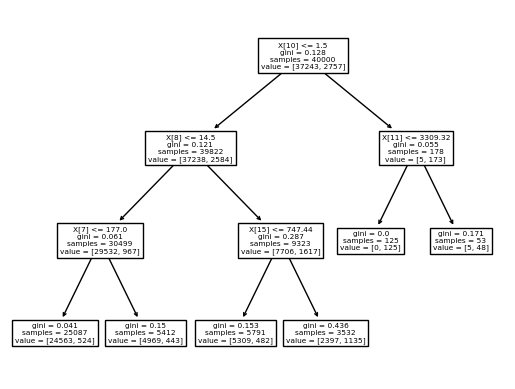

In [5]:
import matplotlib.pyplot as plt

#包里自带的，有点丑
tree.plot_tree(clf)
plt.show()

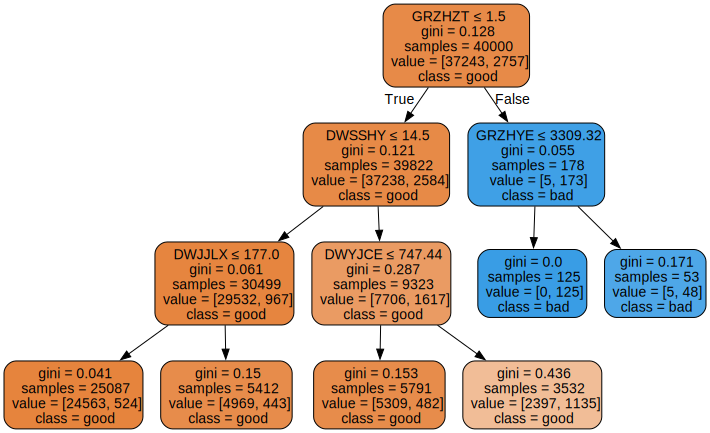

In [6]:

import graphviz 
dot_data = tree.export_graphviz(
                     clf, 
                     out_file=None, 
                     feature_names=X.columns,  
                     class_names=['good','bad'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [7]:
from dtreeviz.trees import dtreeviz
testX = X.iloc[77,:]
viz = dtreeviz(clf,X,Y,
                feature_names=np.array(X.columns),
                class_names={0:'good',1:'bad'},
                X = testX)             

viz.view()

/Users/zhusx/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### 规则提取

In [24]:
def Fun_Get_Rules(clf,X):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves  = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]

    while len(stack) > 0:

        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        is_split_node = children_left[node_id] != children_right[node_id]

        if is_split_node:
            stack.append((children_left[node_id],  depth+1))
            stack.append((children_right[node_id], depth+1))
        else:
            is_leaves[node_id] = True  
    feature_name = [
            X.columns[i] 
            for i in clf.tree_.feature]

    ways  = []
    depth = []
    feat = []
    nodes = []
    rules = []
    for i in range(n_nodes):   
        if  is_leaves[i]: 
            while depth[-1] >= node_depth[i]:
                depth.pop()
                ways.pop()    
                feat.pop()
                nodes.pop()
            if children_left[i-1]==i:#当前节点是上一个节点的左节点，则是小于
                a='{f}<={th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                ways[-1]=a              
                last =' & '.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)
            else:
                a='{f}>{th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                ways[-1]=a
                last = ' & '.join(ways)+':'+str(value[i][0][0])+':'+str(value[i][0][1])
                rules.append(last)

        else: #不是叶子节点 入栈
            if i==0:
                ways.append(round(threshold[i],4))
                depth.append(node_depth[i])
                feat.append(feature_name[i])
                nodes.append(i)             
            else: 
                while depth[-1] >= node_depth[i]:
                    depth.pop()
                    ways.pop()
                    feat.pop()
                    nodes.pop()
                if i==children_left[nodes[-1]]:
                    w='{f}<={th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))
                else:
                    w='{f}>{th}'.format(f=feat[-1],th=round(threshold[nodes[-1]],4))              
                ways[-1] = w  
                ways.append(round(threshold[i],4))
                depth.append(node_depth[i]) 
                feat.append(feature_name[i])
                nodes.append(i)
    return rules

In [25]:
clf = tree.DecisionTreeClassifier(max_depth=5,
min_samples_leaf=50)
clf = clf.fit(X, Y)
Rules = Fun_Get_Rules(clf,X)

In [40]:
df_rule=pd.DataFrame(Rules,columns=['rule'])

In [42]:
df_rule['good']=df_rule['rule'].apply(lambda x:x.split(':')[1])
df_rule['bad']=df_rule['rule'].apply(lambda x:x.split(':')[2])
df_rule['rule']=df_rule['rule'].apply(lambda x:x.split(':')[0])


In [45]:
df_rule['good']=pd.to_numeric(df_rule['good'])
df_rule['bad']=pd.to_numeric(df_rule['bad'])

In [46]:
df_rule['rate']=df_rule['bad']/(df_rule['bad']+df_rule['good'])

In [47]:
df_rule

,rule,good,bad,rate
0,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX<=177.0 & D...,990.0,113.0,0.102448
1,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX<=177.0 & D...,2882.0,115.0,0.038372
2,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX<=177.0 & D...,17841.0,147.0,0.008172
3,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX<=177.0 & D...,2850.0,149.0,0.049683
4,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX>177.0 & DW...,253.0,51.0,0.167763
5,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX>177.0 & DW...,36.0,151.0,0.807487
6,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX>177.0 & DW...,3766.0,109.0,0.028129
7,GRZHZT<=1.5 & DWSSHY<=14.5 & DWJJLX>177.0 & DW...,914.0,132.0,0.126195
8,GRZHZT<=1.5 & DWSSHY>14.5 & GRYJCE<=747.44 & D...,4190.0,273.0,0.061170
9,GRZHZT<=1.5 & DWSSHY>14.5 & GRYJCE<=747.44 & D...,1060.0,175.0,0.141700
